Import data

In [2]:
import os
import folium
import json
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx

from collections import defaultdict
from datetime import datetime
from sklearn.cluster import KMeans
from tqdm import tqdm
from haversine import haversine
from pyvis.network import Network

Load geolife data

In [3]:
data_path = './data/'

# Create an empty list to store DataFrames
dataframes = []
index = 0

# Traverse through user directories
for user_folder in tqdm(os.listdir(data_path)):
	user_folder_path = os.path.join(data_path, user_folder)

	# Check if it's a directory
	if os.path.isdir(user_folder_path):
		trajectory_dir = os.path.join(user_folder_path, 'Trajectory')
		
		# Check if 'Trajectory' directory exists
		if os.path.exists(trajectory_dir) and os.path.isdir(trajectory_dir):
			# Loop through trajectory files for each user
			for trajectory_file in os.listdir(trajectory_dir):
				if trajectory_file.endswith('.plt'):
					trajectory_file_path = os.path.join(trajectory_dir, trajectory_file)
					
					df = pd.read_csv(trajectory_file_path, header=None, skiprows=6)
					df.insert(0, 'person', index)
					dataframes.append(df)
			index += 1

gps_data = pd.concat(dataframes, ignore_index=True)
column_names = ['Person ID', 'Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
gps_data.columns = column_names
gps_data['Timestamp'] = pd.to_datetime(gps_data['Date'] + ' ' + gps_data['Time'])
gps_data = gps_data.drop(columns=['NumDays', 'Date', 'Time', '0'])
gps_data = gps_data[gps_data['Latitude'] >= 39.75]
gps_data = gps_data[gps_data['Latitude'] <= 40.1]
gps_data = gps_data[gps_data['Longitude'] >= 116.18]
gps_data = gps_data[gps_data['Longitude'] <= 116.6]
gps_data

100%|██████████| 182/182 [03:56<00:00,  1.30s/it]


,Person ID,Latitude,Longitude,Altitude,Timestamp
0,0,39.984702,116.318417,492.000000,2008-10-23 02:53:04
1,0,39.984683,116.318450,492.000000,2008-10-23 02:53:10
2,0,39.984686,116.318417,492.000000,2008-10-23 02:53:15
3,0,39.984688,116.318385,492.000000,2008-10-23 02:53:20
4,0,39.984655,116.318263,492.000000,2008-10-23 02:53:25
...,...,...,...,...,...
24876951,181,39.988783,116.299000,114.829396,2008-02-17 10:43:09
24876952,181,39.989500,116.298667,98.425197,2008-02-17 10:43:56
24876953,181,39.990067,116.298350,131.233596,2008-02-17 10:44:26
24876954,181,39.989517,116.298417,150.918635,2008-02-17 10:45:23


Load geolife labels

In [4]:
# Create an empty list to store DataFrames
dataframes = []

# Traverse through user directories
for user_folder in os.listdir(data_path):
	user_folder_path = os.path.join(data_path, user_folder)

	labels_file_path = os.path.join(user_folder_path, 'labels.txt')
					
	# Check if the labels file exists
	if os.path.exists(labels_file_path):
		labels_df = pd.read_csv(labels_file_path, sep='\t')
		
		dataframes.append(labels_df)

data_labels = pd.concat(dataframes, ignore_index=True)
data_labels

,Start Time,End Time,Transportation Mode
0,2007/06/26 11:32:29,2007/06/26 11:40:29,bus
1,2008/03/28 14:52:54,2008/03/28 15:59:59,train
2,2008/03/28 16:00:00,2008/03/28 22:02:00,train
3,2008/03/29 01:27:50,2008/03/29 15:59:59,train
4,2008/03/29 16:00:00,2008/03/30 15:59:59,train
...,...,...,...
14713,2008/11/17 06:59:58,2008/11/17 07:06:16,bus
14714,2008/11/17 07:06:16,2008/11/17 07:14:32,walk
14715,2008/11/29 01:58:05,2008/11/29 02:01:39,bus
14716,2008/11/29 02:01:39,2008/11/29 02:07:57,walk


Load T drive

In [5]:
data_path = './data2/taxi_log_2008_by_id'

dataframes = []

for file in tqdm(os.listdir(data_path)):
	file_path = os.path.join(data_path, file)

	try:
		column_names = ['Taxi ID', 'Timestamp', 'Longitude', 'Latitude']
		labels_df = pd.read_csv(file_path, sep=',', names=column_names)

		dataframes.append(labels_df)
	except pd.errors.EmptyDataError:
		continue

gps_data2 = pd.concat(dataframes, ignore_index=True)
gps_data2 = gps_data2[gps_data2['Latitude'] >= 39.75]
gps_data2 = gps_data2[gps_data2['Latitude'] <= 40.1]
gps_data2 = gps_data2[gps_data2['Longitude'] >= 116.18]
gps_data2 = gps_data2[gps_data2['Longitude'] <= 116.6]

100%|██████████| 10357/10357 [02:05<00:00, 82.77it/s]
C:\Users\danstorm\AppData\Local\Temp\ipykernel_11988\802862341.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gps_data2 = pd.concat(dataframes, ignore_index=True)


Analyze geolife

Distribution of transportation nodes

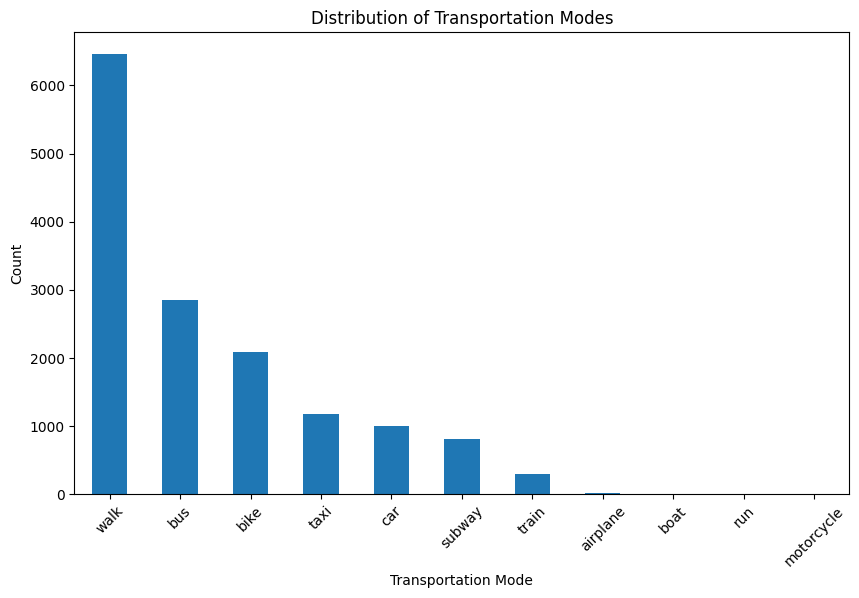

In [6]:
x = data_labels['Transportation Mode'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
x.plot(kind='bar')
plt.xlabel('Transportation Mode')
plt.ylabel('Count')
plt.title('Distribution of Transportation Modes')
plt.xticks(rotation=45)
plt.show()

Heatmap GPS density

In [7]:
n_samples = 20000
new_data = gps_data.sample(n=20000, replace=False, random_state=42)

fig = px.density_mapbox(
	new_data, 
	lat='Latitude', 
	lon='Longitude', 
	radius=10,
	center=dict(lat=new_data['Latitude'].mean(), lon=new_data['Longitude'].mean()),
	zoom=10,
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Clusterring Data

In [8]:
new_data = gps_data.sample(n=20000, replace=False, random_state=42)

kmeans = KMeans(n_clusters=5)
kmeans.fit(new_data[['Latitude', 'Longitude']])

# Get cluster labels for each data point
cluster_labels = kmeans.labels_
new_data['Cluster'] = cluster_labels

m = folium.Map(location=[new_data['Latitude'].mean(), new_data['Longitude'].mean()], zoom_start=10)

cluster_color = ['blue', 'red', 'yellow', 'pink', 'black']

for cluster in new_data['Cluster'].unique():
	cluster_data = new_data[new_data['Cluster'] == cluster]
	for index, row in cluster_data.iterrows():
		folium.CircleMarker(location=[row['Latitude'], row['Longitude']], radius=5, color=f'{cluster_color[cluster]}').add_to(m)

m.save('./files/graphs/cluster_map_geolife.html')

c:\Users\danstorm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Display on a map

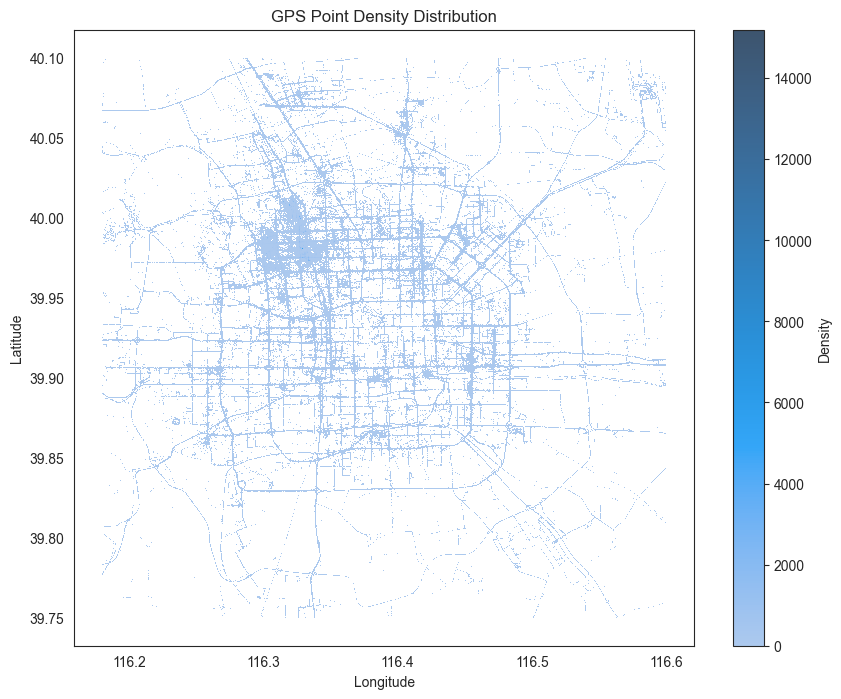

In [9]:
my_map = folium.Map(location=[39.90, 116.41], zoom_start=12)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=gps_data, x='Longitude', y='Latitude', bins=2600, cbar=True, cbar_kws={'label': 'Density'}, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GPS Point Density Distribution')

plt.savefig('./img/density_plot_geolife.png', dpi=300)

Analyze T drive

Calculate distance

In [10]:
def calculate_distance(lat1, lon1, lat2, lon2):
	R = 6371
	lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
	dlat = lat2 - lat1
	dlon = lon2 - lon1
	a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
	c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
	distance = R * c
	return distance * 1000

Time differences between data points

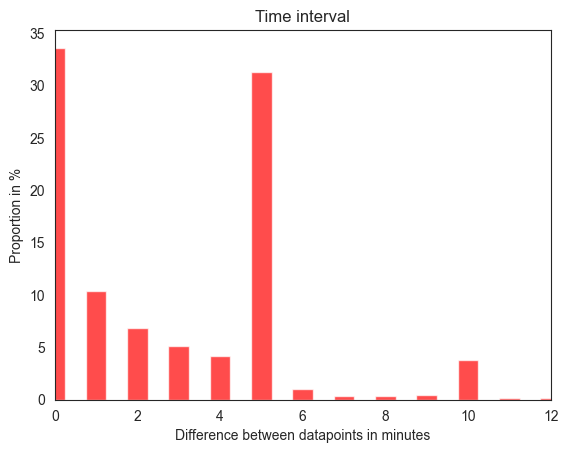

In [13]:
new_data2 = gps_data2.copy()
new_data2['Timestamp'] = pd.to_datetime(gps_data2['Timestamp'])
new_data2['TimeDifference'] = round(new_data2.groupby('Taxi ID')['Timestamp'].diff().dt.total_seconds() / 60)
timeDiff = new_data2['TimeDifference'].value_counts(normalize=True) * 100

x = timeDiff.index
y = timeDiff.values

plt.bar(x, y, color='red', alpha=0.7, width=0.5)
plt.ylabel('Proportion in %')
plt.xlabel('Difference between datapoints in minutes')
plt.title('Time interval')
plt.xlim(0, 12)
plt.show()

Distance interval

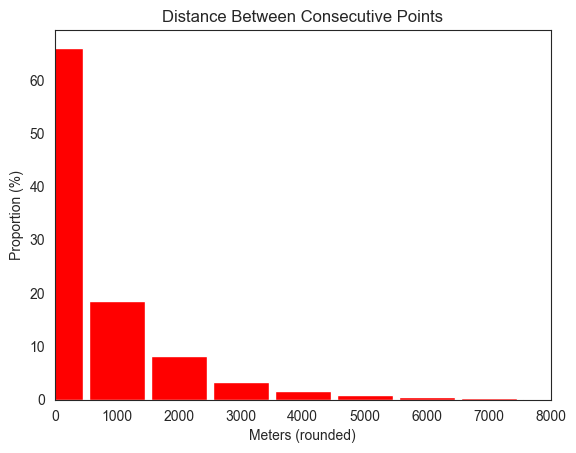

In [14]:
new_data2['DistanceDifference'] = gps_data2.groupby('Taxi ID').apply(
	lambda group: calculate_distance(group['Latitude'], group['Longitude'], group['Latitude'].shift(), group['Longitude'].shift())
).reset_index(drop=True)

new_data2 = new_data2[new_data2['Taxi ID'] == new_data2['Taxi ID'].shift(-1)]
new_data2.loc[:, 'DistanceDifference'] = (new_data2['DistanceDifference'] / 1000).round() * 1000
distDiff = new_data2['DistanceDifference'].value_counts(normalize=True) * 100

x = distDiff.index
y = distDiff.values

plt.bar(x, y, width=900, color='red')
plt.xlabel('Meters (rounded)')
plt.ylabel('Proportion (%)')
plt.title('Distance Between Consecutive Points')
plt.xlim(0, 8000)
plt.show()

Display on a map

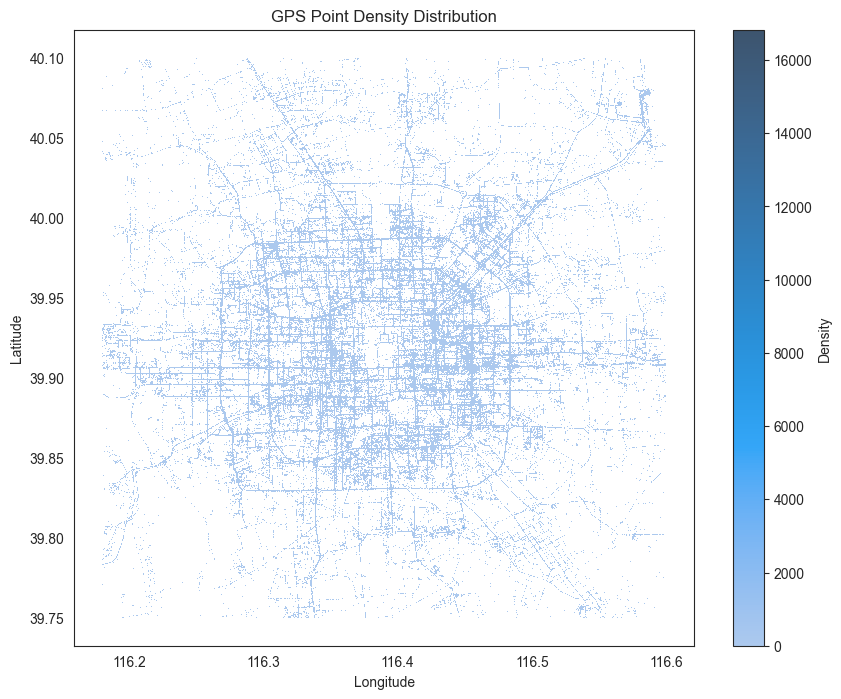

In [15]:
import folium

# Create a folium map centered on Beijing
my_map = folium.Map(location=[39.90, 116.41], zoom_start=12)

sns.set_style("white")
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=gps_data2, x='Longitude', y='Latitude', bins=2600, cbar=True, cbar_kws={'label': 'Density'}, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GPS Point Density Distribution')

plt.savefig('./img/density_plot_tdrive.png', dpi=300)

Heatmap

In [16]:
new_data = gps_data2.sample(n=20000, replace=False, random_state=42)

fig = px.density_mapbox(
	new_data, 
	lat='Latitude', 
	lon='Longitude', 
	radius=10,
	center=dict(lat=new_data['Latitude'].mean(), lon=new_data['Longitude'].mean()),
	zoom=10,
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Node analysis

In [ ]:
def calculate_distance(coord1, coord2):
	return haversine(coord1, coord2)

meeting_distance_threshold = 0.1

Geolife node analysis

Extract nodes

In [ ]:
unique_taxi_ids = gps_data['Person ID'].unique()
unique_taxi_ids_df = pd.DataFrame({'Person ID': unique_taxi_ids})
unique_taxi_ids_df.to_csv('./files/nodes/geolife.csv', index=False)

Save close coordinates

In [ ]:
meeting_points = defaultdict(list)
meeting_info_list = []

for index, row in tqdm(gps_data.iterrows(), desc="main data"):
	taxi_id = row["Person ID"]
	location = (row["Latitude"], row["Longitude"])

	if meeting_points[location]:
		for other_taxi_id in meeting_points[location]:
			if taxi_id != other_taxi_id:
				other_location = (gps_data.loc[gps_data["Person ID"] == other_taxi_id, "Latitude"].iloc[0], gps_data.loc[gps_data["Person ID"] == other_taxi_id, "Longitude"].iloc[0])

				distance = calculate_distance(location, other_location)
				if distance <= meeting_distance_threshold:
					meeting_info = {
						"Taxi1": int(other_taxi_id),
						"Taxi2": int(taxi_id),
						"Location": {
							"Latitude": location[0],
							"Longitude": location[1]
						},
						"Distance (meters)": distance,
						"Timestamp1": row["Timestamp"],
						"Timestamp2": gps_data.loc[gps_data["Person ID"] == other_taxi_id, "Timestamp"].iloc[0]
					}

					meeting_info_list.append(meeting_info)
                      
	meeting_points[location].extend([taxi_id])

Save

In [ ]:
with open('./files/edges/geolife.json', 'w') as json_file:
    json.dump(meeting_info_list, json_file, indent=4)

Tdrive node analysis

Extract nodes

In [ ]:
unique_taxi_ids = gps_data2['Taxi ID'].unique()
unique_taxi_ids_df = pd.DataFrame({'Taxi ID': unique_taxi_ids})
unique_taxi_ids_df.to_csv('./files/nodes/tdrive.csv', index=False)

Save close coords

In [ ]:
meeting_points = defaultdict(list)
meeting_distance_threshold = 0.1
meeting_info_list = []

for index, row in tqdm(gps_data2.iterrows(), desc="main data"):
	taxi_id = row["Taxi ID"]
	location = (row["Latitude"], row["Longitude"])

	if meeting_points[location]:
		for other_taxi_id in meeting_points[location]:
			if taxi_id != other_taxi_id:
				other_location = (gps_data2.loc[v["Taxi ID"] == other_taxi_id, "Latitude"].iloc[0], gps_data2.loc[gps_data2["Taxi ID"] == other_taxi_id, "Longitude"].iloc[0])

				distance = calculate_distance(location, other_location)
				if distance <= meeting_distance_threshold:
					meeting_info = {
						"Taxi1": int(other_taxi_id),
						"Taxi2": int(taxi_id),
						"Location": {
							"Latitude": location[0],
							"Longitude": location[1]
						},
						"Distance (meters)": distance,
						"Timestamp1": row["Timestamp"],
						"Timestamp2": gps_data2.loc[gps_data2["Taxi ID"] == other_taxi_id, "Timestamp"].iloc[0]
					}

					meeting_info_list.append(meeting_info)

	meeting_points[location].extend([taxi_id])

Save

In [ ]:
with open('./files/edges/tdrive.json', 'w') as json_file:
    json.dump(meeting_info_list, json_file, indent=4)

Convert json to csv

In [ ]:
def load_json(file_path):
	with open(file_path, 'r') as json_file:
		data = json.load(json_file)
	return data

def extract_unique_pairs(data, include_time, time_threshold):
	unique_pairs = set()
	for entry in data:
		taxi1 = entry.get('Taxi1')
		taxi2 = entry.get('Taxi2')

		timestamp1 = datetime.strptime(entry.get('Timestamp1'), "%Y-%m-%d %H:%M:%S")
		timestamp2 = datetime.strptime(entry.get('Timestamp2'), "%Y-%m-%d %H:%M:%S")

		if taxi1 is not None and taxi2 is not None:
			if include_time == True:
				if abs((timestamp1 - timestamp2).total_seconds()) <= time_threshold:
					pair = tuple(sorted([taxi1, taxi2]))
					unique_pairs.add(pair)
			else:
				pair = tuple(sorted([taxi1, taxi2]))
				unique_pairs.add(pair)

	return list(unique_pairs)

def save_to_csv(unique_pairs, csv_file, person):
	with open(csv_file, 'w', newline='') as csvfile:
		csv_writer = csv.writer(csvfile)
		if(person == True):
			csv_writer.writerow(['Person1', 'Person2'])
		else:
			csv_writer.writerow(['Taxi1', 'Taxi2'])

		for pair in unique_pairs:
			csv_writer.writerow(pair)

def process_json(json_file_path, csv_file_path, person):
	data = load_json(json_file_path)

	unique_pairs = extract_unique_pairs(data, False, 60)
	save_to_csv(unique_pairs, csv_file_path + '.csv', person)
	print(f"Unique pairs saved to {csv_file_path + '.csv'}")

	unique_pairs = extract_unique_pairs(data, True, 60)
	save_to_csv(unique_pairs, csv_file_path + '_time_1min.csv', person)
	print(f"Unique pairs saved to {csv_file_path + '_time_1min.csv'}")

	unique_pairs = extract_unique_pairs(data, True, 60 * 30)
	save_to_csv(unique_pairs, csv_file_path + '_time_30min.csv', person)
	print(f"Unique pairs saved to {csv_file_path + '_time_30min.csv'}")

	unique_pairs = extract_unique_pairs(data, True, 60 * 60 * 24)
	save_to_csv(unique_pairs, csv_file_path + '_time_1day.csv', person)
	print(f"Unique pairs saved to {csv_file_path + '_time_1day.csv'}")

process_json('./files/edges/geolife.json', './files/edges/geolife', True)
process_json('./files/edges/tdrive.json', './files/edges/tdrive', False)

Analyze data

Load data

In [ ]:
data1 = pd.read_csv("./files/edges/geolife.csv")
data2 = pd.read_csv("./files/edges/geolife_time_1min.csv")
data3 = pd.read_csv("./files/edges/geolife_time_30min.csv")
data4 = pd.read_csv("./files/edges/geolife_time_1day.csv")

data1_nodes = pd.read_csv("./files/nodes/geolife.csv")
max_node_number1 = data1_nodes["Person ID"].max()

data5 = pd.read_csv("./files/edges/tdrive.csv")
data6 = pd.read_csv("./files/edges/tdrive_time_1min.csv")
data7 = pd.read_csv("./files/edges/tdrive_time_30min.csv")
data8 = pd.read_csv("./files/edges/tdrive_time_1day.csv")

data5_nodes = pd.read_csv("./files/nodes/tdrive.csv")
max_node_number2 = data5_nodes["Taxi ID"].max()

Analyze function

In [ ]:
def analyze(edges_df, nodes_df, node_max, taxi1, taxi2, node, graph_label):
	merged_edges_df = pd.merge(nodes_df, edges_df, left_on=node, right_on=taxi1, how="left")
	merged_edges_df.fillna(0, inplace=True)

	all_numbers = pd.concat([edges_df[taxi1], edges_df[taxi2]])
	most_common_number = all_numbers.mode().iloc[0]
	max_occurrences = all_numbers.value_counts().max()

	occurrences_counts = all_numbers.value_counts().reindex(range(1, node_max + 1), fill_value=0)
	least_common_number = occurrences_counts.idxmin()
	min_occurrences = occurrences_counts.loc[least_common_number]

	nodes_occurrences_df = pd.DataFrame({'Node': all_numbers.value_counts().index, 'Occurrences': all_numbers.value_counts().values})

	unique_persons = set(edges_df[taxi1]).union(set(edges_df[taxi2]))

	num_edges = len(edges_df)
	num_nodes = len(unique_persons)

	# Average number of edges per node
	avg_edges_per_node = (num_edges / node_max) * 2
	avg_edges_per_active_node = (num_edges / num_nodes) * 2

	print(f"Number of edges: {num_edges}")
	print(f"Number of nodes: {node_max}")
	print(f"Number of nodes with edges: {num_nodes}")
	print(f"Max number of edges from a node: Node {most_common_number} with {max_occurrences} edges")
	print(f"Min number of edges from a node: Node {least_common_number} with {min_occurrences} edges")
	print(f"Average number of edges per node: {avg_edges_per_node:.2f}")
	print(f"Average number of edges per active node: {avg_edges_per_active_node:.2f}")

	plt.figure(figsize=(10, 6))
	plt.bar(nodes_occurrences_df["Node"], nodes_occurrences_df["Occurrences"])
	plt.title("Nodes and Their Occurrences for " + graph_label)
	plt.xlabel("Node number")
	plt.ylabel("Occurrences")
	plt.show()

	plt.figure(figsize=(10, 6))
	plt.hist(nodes_occurrences_df["Occurrences"], bins=20, color='blue', edgecolor='black')
	plt.title("Distribution of Node Occurrences for " + graph_label)
	plt.xlabel("Number of edges for a node")
	plt.ylabel("Number of Nodes having that many edges")
	plt.show()

Analyze data

In [1]:
analyze(data1, data1_nodes, max_node_number1, "Person1", "Person2", "Person ID", "Geolife full")
analyze(data2, data1_nodes, max_node_number1, "Person1", "Person2", "Person ID", "Geolife 1 minute")
analyze(data3, data1_nodes, max_node_number1, "Person1", "Person2", "Person ID", "Geolife 30 minutes")
analyze(data4, data1_nodes, max_node_number1, "Person1", "Person2", "Person ID", "Geolife 1 day")
analyze(data5, data5_nodes, max_node_number2, "Taxi1", "Taxi2", "Taxi ID", "T drive full")
analyze(data6, data5_nodes, max_node_number2, "Taxi1", "Taxi2", "Taxi ID", "T drive 1 minute")
analyze(data7, data5_nodes, max_node_number2, "Taxi1", "Taxi2", "Taxi ID", "T drive 30 minutes")
analyze(data8, data5_nodes, max_node_number2, "Taxi1", "Taxi2", "Taxi ID", "T drive 1 day")

NameError: name 'analyze' is not defined

Visualize

Visualize JSON

In [ ]:
meeting_data = []

def load_csv(file_path):
	with open(file_path, 'r') as csvfile:
		reader = csv.reader(csvfile)
		next(reader)
		edges = [tuple(map(int, row)) for row in reader]

	return edges

# Open the JSON file for reading
with open("./files/edges/geolife.json", "r") as json_file:
	meeting_data = json.load(json_file)

node_path = './files/nodes/geolife.csv'
nodes = load_csv(node_path)

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(nodes)

# ADJUST THRESHOLDS HERE
include_time = True
time_threshold = 60 # 60 seconds
distance_threshold = 0.005 # 50 meters

for meeting in meeting_data:
	if(meeting["Distance (meters)"] < distance_threshold):
		taxi1 = meeting["Taxi1"]
		taxi2 = meeting["Taxi2"]
		timestamp1 = datetime.strptime(meeting["Timestamp1"], "%Y-%m-%d %H:%M:%S")
		timestamp2 = datetime.strptime(meeting["Timestamp2"], "%Y-%m-%d %H:%M:%S")
		
		if include_time == True:
			if abs((timestamp1 - timestamp2).total_seconds()) <= time_threshold:
				# G.add_node(taxi1)
				# G.add_node(taxi2)
				G.add_edge(taxi1, taxi2)
		else:
			# G.add_node(taxi1)
			# G.add_node(taxi2)
			G.add_edge(taxi1, taxi2)

pos = nx.spring_layout(G)

# Convert node labels to strings
node_trace = go.Scatter(
	x=[pos[x][0] for x in G.nodes()],
	y=[pos[x][1] for x in G.nodes()],
	mode="markers",
	marker=dict(size=10, color="blue"),
	text=[str(node) for node in G.nodes()],
	hoverinfo="text"
)

edge_x = []
edge_y = []
for edge in G.edges():
	x0, y0 = pos[edge[0]]
	x1, y1 = pos[edge[1]]
	edge_x.append(x0)
	edge_x.append(x1)
	edge_x.append(None)
	edge_y.append(y0)
	edge_y.append(y1)
	edge_y.append(None)

edge_trace = go.Scatter(
	x=edge_x,
	y=edge_y,
	line=dict(width=1, color="#888"),
	hoverinfo="none",
	mode="lines"
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
	showlegend=False,
	hovermode="closest",
	title="Interactive Taxi Meeting Visualization",
	xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
	yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
)

fig.show()

Visualize CSV

In [ ]:
def load_csv(file_path):
	with open(file_path, 'r') as csvfile:
		reader = csv.reader(csvfile)
		next(reader)
		edges = [tuple(map(int, row)) for row in reader]

	return edges

def draw_graph(edges, nodes):
	G = nx.Graph()

	G.add_nodes_from(nodes)
	G.add_edges_from(edges)

	pos = nx.spring_layout(G)

	node_trace = go.Scatter(
		x=[pos[x][0] for x in G.nodes()],
		y=[pos[x][1] for x in G.nodes()],
		mode="markers",
		marker=dict(size=10, color="blue"),
		text=[str(node) for node in G.nodes()],
		hoverinfo="text"
	)

	edge_x = []
	edge_y = []
	for edge in G.edges():
		x0, y0 = pos[edge[0]]
		x1, y1 = pos[edge[1]]
		edge_x.extend([x0, x1, None])
		edge_y.extend([y0, y1, None])

	edge_trace = go.Scatter(
		x=edge_x,
		y=edge_y,
		line=dict(width=1, color="#888"),
		hoverinfo="none",
		mode="lines"
	)

	fig = go.Figure(data=[edge_trace, node_trace])
	fig.update_layout(
		showlegend=False,
		hovermode="closest",
		title="Interactive Taxi Meeting Visualization",
		xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
		yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
	)

	fig.show()

node_path = './files/nodes/geolife.csv'
nodes = load_csv(node_path)

csv_file_path = './files/edges/geolife.csv'
edges = load_csv(csv_file_path)
draw_graph(edges)

csv_file_path = './files/edges/geolife_time_1min.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

csv_file_path = './files/edges/geolife_time_30min.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

csv_file_path = './files/edges/geolife_time_1day.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

node_path = './files/nodes/tdrive.csv'
nodes = load_csv(node_path)

csv_file_path = './files/edges/tdrive.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

csv_file_path = './files/edges/tdrive_time_1min.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

csv_file_path = './files/edges/tdrive_time_30min.csv'
edges = load_csv(csv_file_path)
draw_graph(edges, nodes)

csv_file_path = './files/edges/tdrive_time_1day.csv'
edges = load_csv(csv_file_path)
draw_graph(edges)

Visualize using Pyvis

In [ ]:
def load_csv(file_path):
	with open(file_path, 'r') as csvfile:
		reader = csv.reader(csvfile)
		next(reader)
		edges = [tuple(map(int, row)) for row in reader]

	return edges

def visualize_graph(edges, nodes):
	G = nx.Graph()
	G.add_nodes_from(map(str, nodes))
	G.add_edges_from(edges)

	nt = Network(directed=False, notebook=True)

	for node in G.nodes:
		nt.add_node(str(node), title=str(node), label=str(node))

	nt.from_nx(G)

	nt.show('./files/graphs/graph3.html')

# ADJUST FILE PATH HERE
node_path = './files/nodes/geolife.csv'
edges_path = './files/edges/geolife_time_1min.csv'
edges = load_csv(edges_path)
nodes = load_csv(node_path)
visualize_graph(edges, nodes)